In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score


# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb

# Table of contents
- data preprocessing
    - data import
    - missing values
- data exploration
    - Target distribution
- Label encoding
- Model building
- Submission

## data import & identifcation

In [3]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
oridinal_features = ['Pclass']
catagorical_features = ['Sex', 'Embarked']
other_features = ['Ticket', 'Cabin']

# missing values

In [9]:
(df_train.isnull().sum() / len(df_train) * 100).round(2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [10]:
(df_test.isnull().sum() / len(df_train) * 100).round(2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age             9.65
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.11
Cabin          36.70
Embarked        0.00
dtype: float64

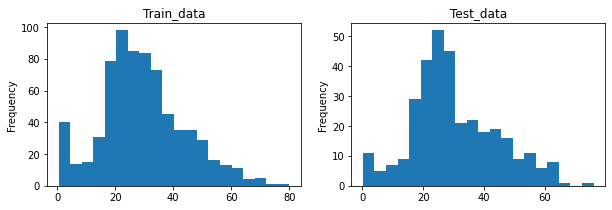

In [11]:
# Features with missing values in df_train = Age (19.87%), Cabin (77.10%), Embarked (0.22%)
# Features with missing values in df_test = Age (9.65%), Cabin (36.70%), Fare (0.11%)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
df_train['Age'].plot(kind='hist', bins=20)
plt.title('Train_data')

plt.subplot(1, 2, 2)
df_test['Age'].plot(kind='hist', bins=20)
plt.title('Test_data')

plt.show();

In [12]:
df_train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [13]:
df_train = df_train.drop(labels='Cabin', axis=1)
df_test = df_test.drop(labels='Cabin', axis=1)

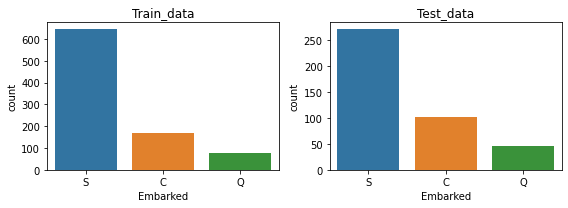

In [14]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.countplot(data=df_train, x='Embarked', order=['S', 'C', 'Q'])
plt.title('Train_data')

plt.subplot(1, 2, 2)
sns.countplot(data=df_test, x='Embarked',order=['S', 'C', 'Q'])
plt.title('Test_data')

plt.tight_layout()
plt.show();

In [15]:
missed_embarked_indexes = df_train[df_train.Embarked.isnull()].index

df_train = df_train.drop(index=missed_embarked_indexes, axis=0)
df_train.shape

(889, 11)

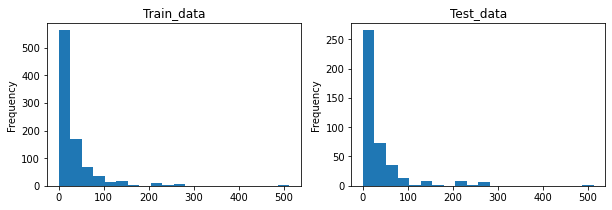

In [16]:
# Features with missing values in df_train = Age (19.87%), Cabin (77.10%), Embarked (0.22%)
# Features with missing values in df_test = Age (9.65%), Cabin (36.70%), Fare (0.11%)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
df_train['Fare'].plot(kind='hist', bins=20)
plt.title('Train_data')

plt.subplot(1, 2, 2)
df_test['Fare'].plot(kind='hist', bins=20)
plt.title('Test_data')

plt.show();

<AxesSubplot:>

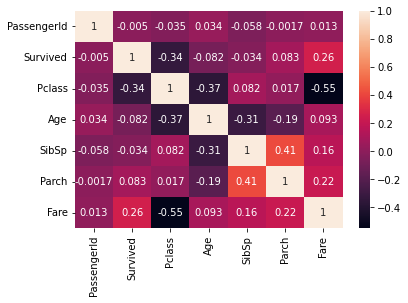

In [17]:
data = df_train.corr()
sns.heatmap(data=data, annot=True)

# highly correlated with Fare features


In [18]:
df_test[df_test.Fare.isnull()]

# fill in the Fare values in df_test later...

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


# Data exploration

- numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
- oridinal_features = ['Pclass']
- catagorical_features = ['Sex', 'Embarked']
- other_features = ['Ticket', 'Cabin']

## Target Feature (Survived) distribution

<AxesSubplot:xlabel='Survived', ylabel='count'>

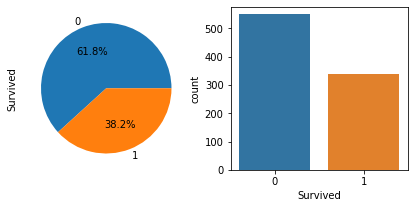

In [19]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
df_train.Survived.value_counts().plot(kind='pie', autopct='%.1f%%')

plt.subplot(1, 2, 2)
sns.countplot(data=df_train, x='Survived')

## Oridinal_features
- Pclass
- Passengers in higher classes (Pclass 1) have a higher survival rate.

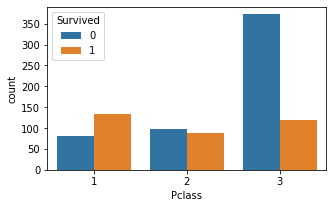

In [20]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_train, x='Pclass', hue='Survived')

plt.show();

In [21]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Pclass,,,
1,80,134,214
2,97,87,184
3,372,119,491
All,549,340,889


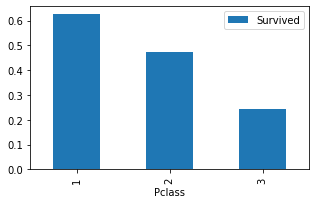

In [22]:
# plt.figure(figsize=(5, 3))
df_train[['Pclass', 'Survived']].groupby(by='Pclass').mean().plot(kind='bar', figsize=(5, 3))
plt.show();

## Oridinal_features
- catagorical_features = ['Sex', 'Embarked']


### Sex VS Survived
- Females have a higher survival rate than males.

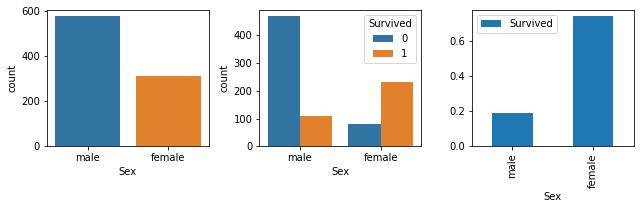

In [23]:
plt.figure(figsize=(9, 3))
ax0 =plt.subplot(1, 3, 1)
sns.countplot(data=df_train, x='Sex')


ax1 = plt.subplot(1, 3, 2)
sns.countplot(data=df_train, x='Sex', hue='Survived')

ax2 = plt.subplot(1, 3, 3)
df_train[['Sex', 'Survived']].groupby(by='Sex').mean().loc[['male', 'female']].plot(kind='bar', ax=ax2,)

plt.tight_layout()
plt.show();

In [24]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Sex,,,
female,81,231,312
male,468,109,577
All,549,340,889


### Embarked vs Survived

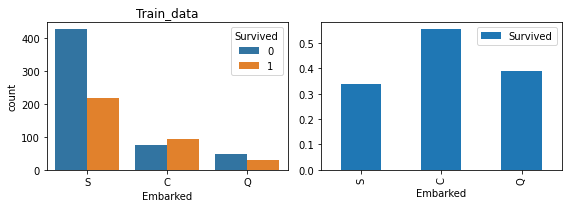

In [25]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.countplot(data=df_train, x='Embarked', order=['S', 'C', 'Q'], hue='Survived')
plt.title('Train_data')

ax = plt.subplot(1, 2, 2)
df_train[['Embarked', 'Survived']].groupby(by='Embarked').mean().loc[['S', 'C', 'Q']].plot(kind='bar', ax=ax)

plt.tight_layout()
plt.show();

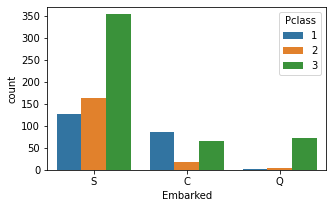

In [26]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_train, x='Embarked', hue='Pclass')
plt.show();

## Nucerical features

- numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']


### Age
- Feature age has missing values in both df_train and df_test

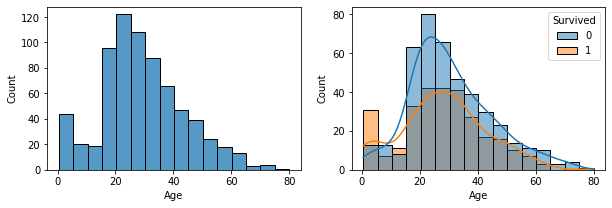

In [27]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='Age', bins=16)

plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='Age', bins=16, hue='Survived', kde=True)

plt.show();

In [28]:
# Survival rate depending on Age

print(df_train.Age.max())
print(df_train.Age.min())

80.0
0.42


In [29]:
Age_interval = np.arange(0, 81, 5)

def Age_interval(age):
    Age_interval = np.arange(0, 81, 5)
    for index, interval in enumerate(Age_interval):
        if age <= interval:
            return interval
        
df_train_test = df_train.copy()
df_train_test['Age_interval'] = df_train_test.Age.apply(Age_interval)

In [30]:
Survived_df = df_train_test[['Age_interval', 'Survived']].groupby(by='Age_interval').mean()
Age_num = pd.DataFrame(df_train_test.Age_interval.value_counts())

pd.concat([Survived_df, Age_num], axis=1)

,Survived,Age_interval
5.0,0.704545,44
10.0,0.350000,20
15.0,0.578947,19
20.0,0.343750,96
25.0,0.344262,122
30.0,0.388889,108
35.0,0.465909,88
40.0,0.409091,66
45.0,0.361702,47
50.0,0.410256,39


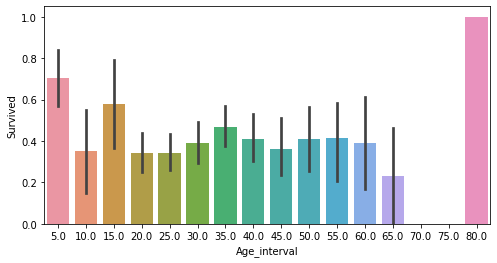

In [31]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_train_test, x='Age_interval', y='Survived')
plt.show();

In [32]:
# However, there are too many missing values of "Age" in dataset

df_train = df_train.drop('Age', axis=1)
df_test = df_test.drop('Age', axis=1)

### Fare
- involved in Pclass
- Mising values in df_test

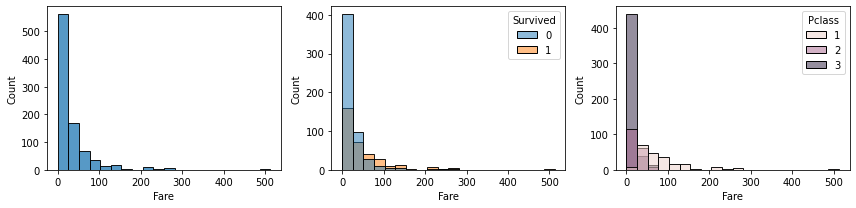

In [33]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.histplot(data=df_train, x='Fare', bins=20)

plt.subplot(1, 3, 2)
sns.histplot(data=df_train, x='Fare', bins=20, hue='Survived')

plt.subplot(1, 3, 3)
sns.histplot(data=df_train, x='Fare', bins=20, hue='Pclass')

plt.tight_layout()
plt.show();

In [34]:
print(df_train.Fare.max())
print(df_train.Fare.min())

512.3292
0.0


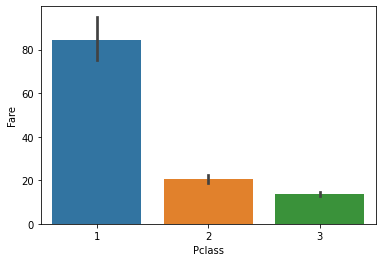

In [35]:
# Fare values are associated with Pclass

plt.figure()
sns.barplot(data=df_train, x='Pclass', y='Fare')
plt.show();

In [36]:
df_test[df_test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,0,0,3701,NaN,S


Pclass_3_max : 69.55, Min : 0.00
Mean : 13.68, Median : 8.05


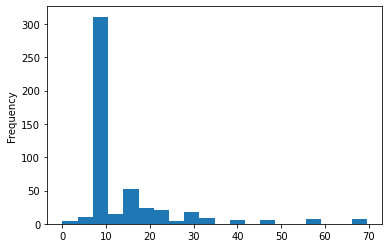

In [37]:
data = df_train[df_train.Pclass == 3]['Fare']

data.plot(kind='hist', bins=20)

print(f'Pclass_3_max : {data.max():.2f}, Min : {data.min():.2f}')
print(f'Mean : {data.mean():.2f}, Median : {data.median():.2f}')

In [38]:
df_test.Fare = df_test.Fare.fillna(value=data.median())
df_test.loc[152]

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
SibSp                           0
Parch                           0
Ticket                       3701
Fare                         8.05
Embarked                        S
Name: 152, dtype: object

In [39]:
# Normalization

def fare_scaler(fare):
    # standard
    # Although this dataset is sample population...
    # z = (x - u) / s
    mean = df_train.Fare.mean()
    std = df_train.Fare.std()
    return (fare - mean) / std

df_train['Fare_std'] = df_train.Fare.apply(fare_scaler)
df_test['Fare_std'] = df_test.Fare.apply(fare_scaler)

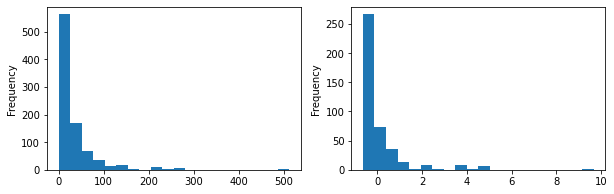

In [40]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
df_train['Fare'].plot(kind='hist', bins=20)

plt.subplot(1, 2, 2)
df_test['Fare_std'].plot(kind='hist', bins=20)

plt.show();

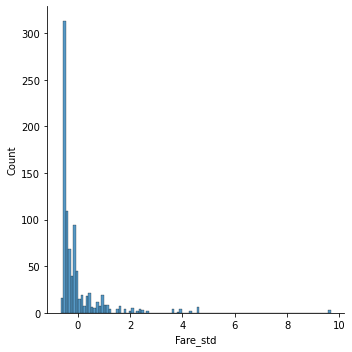

In [41]:
sns.displot(data=df_train, x='Fare_std')

### SibSp, Parch
- Family

In [42]:
df_train['Family_size'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family_size'] = df_test['SibSp'] + df_test['Parch'] + 1

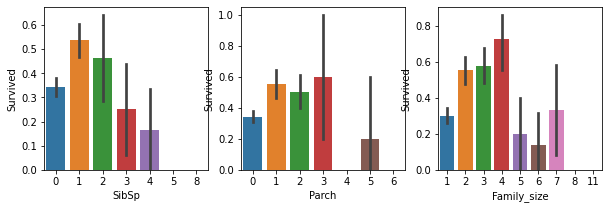

In [43]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
sns.barplot(data=df_train, x='SibSp', y='Survived')

plt.subplot(1, 3, 2)
sns.barplot(data=df_train, x='Parch', y='Survived')

plt.subplot(1, 3, 3)
sns.barplot(data=df_train, x='Family_size', y='Survived')

plt.show();

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Ticket       889 non-null    object 
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    object 
 10  Fare_std     889 non-null    float64
 11  Family_size  889 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 122.6+ KB


In [45]:
columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fare_std', 'Family_size']

df_train_rev = df_train[columns]
df_test_rev = df_test[columns]

target_survival = df_train.Survived.values

In [46]:
df_train_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       889 non-null    int64  
 1   Sex          889 non-null    object 
 2   SibSp        889 non-null    int64  
 3   Parch        889 non-null    int64  
 4   Embarked     889 non-null    object 
 5   Fare_std     889 non-null    float64
 6   Family_size  889 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 87.9+ KB


In [47]:
df_train_rev2 = df_train_rev.copy()
df_test_rev2 = df_test_rev.copy()

labelencoder_sex = LabelEncoder()
labelencoder_embarked = LabelEncoder()


df_train_rev2['Sex'] = labelencoder_sex.fit_transform(df_train_rev.Sex)
df_test_rev2['Sex'] = labelencoder_sex.transform(df_test_rev.Sex)

df_train_rev2['Embarked'] = labelencoder_embarked.fit_transform(df_train_rev.Embarked)
df_test_rev2['Embarked'] = labelencoder_embarked.transform(df_test_rev.Embarked)

In [48]:
df_train_rev2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       889 non-null    int64  
 1   Sex          889 non-null    int64  
 2   SibSp        889 non-null    int64  
 3   Parch        889 non-null    int64  
 4   Embarked     889 non-null    int64  
 5   Fare_std     889 non-null    float64
 6   Family_size  889 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 87.9 KB


In [49]:
df_train_final = df_train_rev2.copy()
df_test_final = df_test_rev2.copy()

X_train, X_val, y_train, y_val = train_test_split(df_train_final, target_survival, test_size=0.2, random_state=123, stratify=target_survival)

## Model building
- RandomForest

In [50]:
def model_score(model):
    # train dataset and  val dataset were already defined
    
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    
    train_score = accuracy_score(y_train, pred_train)
    val_score = accuracy_score(y_val, pred_val)
    print(f'{model}\nTrain socre : {train_score * 100:.2f}, Val score : {val_score * 100:.2f}\n')

In [51]:
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
model_svm = SVC()
model_nb = GaussianNB()
model_xgb = xgb.XGBClassifier()

models = [model_lr, model_rf, model_svm, model_nb, model_xgb]
model_name = ['model_lr','model_rf', 'model_svm', 'model_nb', 'model_xgb']


for model in models:
    model.fit(X_train, y_train)
    model_score(model)

LogisticRegression()
Train socre : 79.32, Val score : 81.46

RandomForestClassifier()
Train socre : 93.11, Val score : 76.97

SVC()
Train socre : 80.87, Val score : 83.15

GaussianNB()
Train socre : 77.50, Val score : 79.21

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Train socre : 92.26, Val score : 80.90



In [52]:
model_name = ['model_lr','model_rf', 'model_svm', 'model_nb', 'model_xgb']
means = []
stds = []
    
for model in models:    
    result = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, scoring='accuracy')
    means.append(result.mean())
    stds.append(result.std())

pd.DataFrame(index=model_name, data={'mean' : means, 'std' : stds})    

,mean,std
model_lr,0.784793,0.035335
model_rf,0.804432,0.035744
model_svm,0.793194,0.045316
model_nb,0.776332,0.053291
model_xgb,0.801635,0.021931


In [53]:
n_estimator = np.arange(20, 201, 20)
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [2, 3, 4, 5, None]

params = {'n_estimators' : n_estimator, 'criterion' : criterion, 'max_depth' : max_depth}

gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy')
gs.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/p

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, None],
                         'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200])},
             scoring='accuracy')

In [54]:
print(gs.best_score_)
print(gs.best_estimator_)

0.8142913424603565
RandomForestClassifier(criterion='entropy', n_estimators=80)


In [55]:
from sklearn.ensemble import VotingClassifier

model_ensemble =VotingClassifier(
    estimators= [('RBF',SVC(kernel='rbf', probability=True)),
                 ('RFor',RandomForestClassifier(n_estimators=180,random_state=123)),                           
                 ('LR',LogisticRegression()),
                 ('NB',GaussianNB()),
                 ('svm',SVC(kernel='linear', probability=True)),
                 ('xgb', xgb.XGBClassifier())], 
    voting='soft').fit(X_train,y_train)

model_score(model_ensemble)

VotingClassifier(estimators=[('RBF', SVC(probability=True)),
                             ('RFor',
                              RandomForestClassifier(n_estimators=180,
                                                     random_state=123)),
                             ('LR', LogisticRegression()), ('NB', GaussianNB()),
                             ('svm', SVC(kernel='linear', probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=Non...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
     

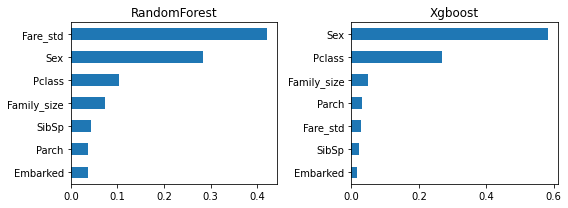

In [56]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
pd.Series(data=model_rf.feature_importances_, index=df_train_final.columns).sort_values().plot(kind='barh')
plt.title('RandomForest')

plt.subplot(1, 2, 2)
pd.Series(data=model_xgb.feature_importances_, index=df_train_final.columns).sort_values().plot(kind='barh')
plt.title('Xgboost')

plt.tight_layout()
plt.show();

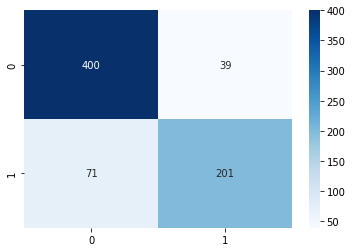

In [57]:
confusion_metrics = metrics.confusion_matrix(y_true=y_train, y_pred=model_ensemble.predict(X_train))
sns.heatmap(confusion_metrics, annot=True, cmap='Blues', fmt='1.0f')
plt.show();

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


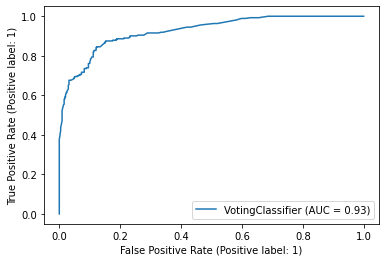

In [58]:
metrics.plot_roc_curve(estimator=model_ensemble, X=X_train, y=y_train)
plt.show();

In [59]:
proba = model_ensemble.predict_proba(X_train)

def roc_curve_plot(model, fpr, tpr, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    auc_score = metrics.roc_auc_score(y_true=y_train, y_score=proba[:, 1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'model (AUC : {auc_score:.2f})', marker='o', markersize=2)
    plt.legend()
    plt.show()

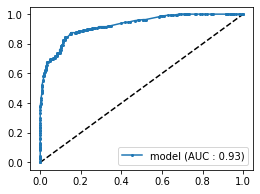

In [60]:
fpr, tpr, thres = metrics.roc_curve(y_true=y_train, y_score=proba[:, 1])

roc_curve_plot(model_ensemble, fpr, tpr, figsize=(4, 3))

In [61]:
prediction = model_ensemble.predict(df_test_final)
submission['Survived'] = prediction

In [62]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [63]:
submission.to_csv('submission.csv', index=False)